# GPyTorch Regression Tutorial

See: [The online doc](https://docs.gpytorch.ai/en/v1.12/examples/01_Exact_GPs/Simple_GP_Regression.html)

## Imports

In [1]:
import logging
import math

from dotenv import load_dotenv

import gpytorch

from matplotlib import pyplot as plt

import torch


%load_ext autoreload
%autoreload 2

# Logger
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO,
    datefmt='%I:%M:%S'
)

# Load dotenv
_ = load_dotenv()

## Define training data

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

## Set up the Model

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)



## Train the model

In [4]:
n_epochs = 50

# Find optimal hyperparameters
model.train()
likelihood.train()

# Use Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Marginal likelihood to serve as loss
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


for n in range(n_epochs):
    # Set gradients to zero
    model.zero_grad()

    # Get ouput
    pred = model(train_x)

    # Loss and update params
    # loss = -mll(pred, model._train_targets)
    loss = -mll(pred, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        n + 1, n_epochs, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.944   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.912   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.878   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.841   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.799   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.752   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.701   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.651   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.603   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.559   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.520   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.484   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.450   lengthscale: 0.273   noise: 0.259
Iter 14/50 - Loss: 0.417   lengthscale: 0.256   noise: 0.237
Iter 15/50 - Loss: 0.385   lengthscale: 0.243   noise: 0.216
Iter 16/50 - Loss: 0.353   lengthscale: 0.233   noise: 0.197
Iter 17/50 - Loss: 0.322   length

## Make predictions

In [5]:
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

NameError: name 'test_x' is not defined

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

## Plot model fit

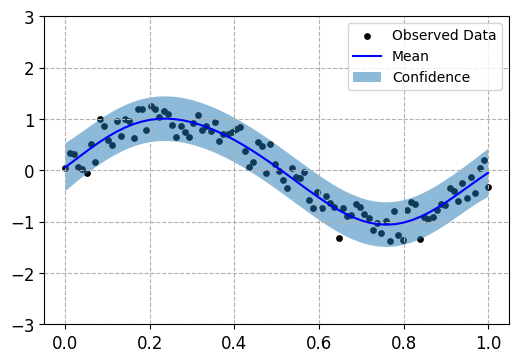

In [10]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.grid(ls='--')

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.scatter(train_x.numpy(), train_y.numpy(), s=15, c='k',)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])


In [13]:
observed_pred.mean

tensor([ 0.0582,  0.1832,  0.3080,  0.4295,  0.5448,  0.6512,  0.7462,  0.8281,
         0.8953,  0.9469,  0.9824,  1.0020,  1.0060,  0.9951,  0.9704,  0.9327,
         0.8833,  0.8233,  0.7536,  0.6752,  0.5887,  0.4951,  0.3948,  0.2887,
         0.1773,  0.0617, -0.0570, -0.1776, -0.2985, -0.4178, -0.5334, -0.6432,
        -0.7447, -0.8356, -0.9136, -0.9766, -1.0229, -1.0509, -1.0599, -1.0493,
        -1.0194, -0.9710, -0.9053, -0.8242, -0.7300, -0.6253, -0.5132, -0.3966,
        -0.2786, -0.1622, -0.0502])